## Basic Exploration of Datasets

In this initial section of the notebook, the focus is on the essential data cleaning and transformation processes needed to establish a robust dataset for the mineral exploration dashboard, specifically targeting rare earth elements (REEs).

### Raster Data Preparation
For the raster data, I will adjust the resolution to 250 meters, aligning it with the analytical scale. It's crucial to note that while this resolution is suitable in meters, when we transform the data into the EPSG:4269 Coordinate Reference System (CRS), the resolution will be expressed in degrees. This adjustment in CRS and resolution is critical for maintaining accurate spatial relationships across the dataset.

### Iterative Approach and Regional Focus
- **Initial Cleaning Scope**: Initially, the data cleaning efforts will be concentrated solely on the British Columbia province. This focused approach will help us in developing the MVP (Minimum Viable Product) for the dashboard.
- **Data Sources**: We will begin with radiometric data and plan to incorporate additional variables in future iterations of the project, progressively enriching our dataset.

## Datasets

Layer Name | Details | Source |
--- | --- | --- | 
admin_boundaries | shapefile - polygons| [Goverment of Canada](https://www.sciencebase.gov/catalog/item/5ab555c6e4b081f61ab78093) | 
critical_minerals | shapefile - points  | [as above](https://open.canada.ca/data/en/dataset/22b2db8a-dc12-47f2-9737-99d3da921751/resource/47e4cbb0-e19c-47c5-9c74-b4f68448b0d4)
x | Computed in QGIS from 1:250k geology polygons | [Mineral Resources ](http://www.m.) 
GRAV | Isostatic residual Bouguer anomaly | [Mineral Resources ](https://www.mrt.tas.gov.au/webdoc2//tasgrav_residual.zip) 
GRAV_1VD | 1st vertical derivative of the GRAV layer | as above
GRAV_AS | Analytic signal of the GRAV layer | as above
GRAV_SHP_IDX | [Shape index](https://www.cgg.com/technicalDocuments/cggv_0000019082.pdf) of the GRAV layer | as above
LANDSAT_* | Bands from 30 year 'barest earth' Landsat product ([Roberts, et. al 2019](https://www.nature.com/articles/s41467-019-13276-1)) | [Geoscience Australia](https://www.ga.gov.au/news-events/news/latest-news/30-years-of-australia-at-its-barest)
MAG | Sixth edition total magnetic intensity map of Australia | [Geoscience Australia](https://researchdata.ands.org.au/total-magnetic-intensity-sixth-edition/1237765) 
MAG_1VD | 1st vertical derivative of the MAG layer | as above
MAG_AS | Analytic signal of the MAG layer | as above
MAG_SHP_IDX | Shape index of the MAG layer | as above
RAD_* | K, U, Th and DOSE data from 4th edition radiometric maps of Australia | [Geoscience Australia](https://data.gov.au/search?q=4th%20edition%20radiometrics)

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import functions and reload the module after making changes
from scripts import utilities
import importlib
importlib.reload(utilities)
from scripts.utilities import read_shapefile, check_transform_crs, to_geodataframe,process_and_reproject_rasters, interactive_plot_raster


#General libraries
import pandas as pd
import geopandas as gdp
import os

#Raster
from osgeo import gdal, osr
import rasterio



#Plotting
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

### Shapefiles

#### Admin boundaries
I will utilize polygons to perform "clipping" on raster datasets, initially focusing on British Columbia. This region is specifically chosen for its relevance in the database as a significant area for rare earth elements (REEs), particularly due to the Wicheeda deposit. Over time, I plan to expand the scope of the analysis to include Ontario and Quebec, the other provinces in the database known to possess REE deposits.

Please note that throughout this notebook, I will consistently use utility functions such as `read_shapefile` and `check_transform_crs` from the `utilities` module. This module serves as a central repository for commonly used functions, streamlining processes and ensuring consistency across the entire notebook.

In [2]:
path2 = r'datasets/shp/originals/admin_boundaries.shp'
admin = read_shapefile(path2)
admin=check_transform_crs(admin)

Shapefile loaded with 13 records
Columns: 7
Geometry type: ['MultiPolygon' 'Polygon']
CRS is already correct.


<Axes: >

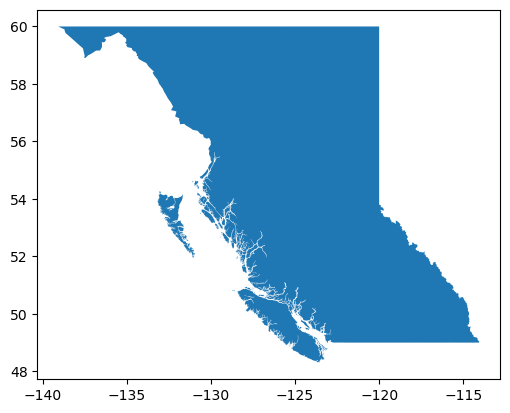

In [3]:
# target_province=admin[admin['PRENAME'].isin(['British Columbia','Nunavut','Ontario','Quebec','Yukon'])]
target_province=admin[admin['PRENAME'].isin(['British Columbia'])]#,'Ontario','Quebec'])]
target_province.plot()

#### Geology and Geochronology
The datasets used in this section are specifically tailored for British Columbia. Thus, they require only a verification of the Coordinate Reference System (CRS) to ensure they align correctly with our analysis parameters. Once this check is completed, the datasets will be ready for immediate use in our explorations.


In [4]:
bc= read_shapefile('datasets\shp\originals\BC_bedrock_ll83.shp')
bc=check_transform_crs(bc)
bc.head(1).iloc[:,10:20]

Shapefile loaded with 35424 records
Columns: 28
Geometry type: ['Polygon']
CRS is already correct.


,mem_phase,rock_class,rock_type,rk_char,unit_desc,age_max,age_min,belt,terrane,basin
0,None,sedimentary rocks,"mudstone, siltstone, shale fine clastic sedime...",None,"Shale, argillite, slate, calcareous argillite,...",Upper Devonian,Permian,Omineca,Cassiar,None


In [5]:
### for simplification we will use just de general lithology unit "rock_class"
bc_rocks=bc.dissolve(by='rock_class')
bc_rocks.reset_index(inplace=True)

In [6]:
new=to_geodataframe(r'datasets\new_age.csv','WGS84-lat','WGS84-long')
# NOTE: The "Sample age" field is not numeric. Six values are ranges such as "170-180".
# It might be useful to either convert these values into a numeric format or exclude them in later steps.

Error reading the file with utf-8. Trying with 'latin1' encoding...
GeoDataFrame created with 532 records
Geometry type: ['Point']
CRS=EPSG:4269


In [7]:
new.to_file(r'datasets\shp\geochronolyBC.shp')

#### Faults


In [2]:
faults= read_shapefile('datasets\shp\originals\BC_faults_ll83.shp')
faults=check_transform_crs(faults)
faults.columns

Shapefile loaded with 57279 records
Columns: 9
Geometry type: ['LineString']
CRS is already correct.


Index(['gid', 'ulid', 'fault_type', 'confidence', 'fault_name', 'length_m',
       'edit_date', 'pub_org', 'geometry'],
      dtype='object')

In [10]:
faults['confidence'].value_counts()

confidence
inferred       6798
approximate    5063
defined        2360
assumed        1411
unknown          62
aproximate        1
Name: count, dtype: int64

#### Critical Minerales occurrences across Canada

_"Critical minerals advanced projects, mines and processing facilities in Canada - Critical minerals in Canada"_ dataset
This dataset contains primary processing facilities (e.g., smelters and refineries), mines and advanced projects related to Canada’s 31 critical minerals[]

In [11]:
path = "datasets\shp\originals\critical_minerals.shp"
CM = read_shapefile(path)
CM=check_transform_crs(CM)
CM.head(2)

Shapefile loaded with 270 records
Columns: 21
Geometry type: ['Point']
Transforming from EPSG:3978 to EPSG:4269.


,OBJECTID,OperationG,Operatio_1,PropertyNa,Property_1,OperatorOw,Operator_1,ProvincesE,ProvincesF,Commoditie,...,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
0,1,Mine,Mine,LaRonde,LaRonde,Agnico Eagle Mines Limited,Mines Agnico Eagle Limitée,Quebec,Québec,"Gold, zinc, copper, silver, cadmium",...,Mine,Mine,Active,En activité,48.2516,-78.428,https://agnicoeagle.com,1,None,POINT (-78.42800 48.25160)
1,2,Mine,Mine,Mount Brussilof,Mount Brussilof,Baymag Inc.,Baymag Inc.,British Columbia,Colombie-Britannique,"Magnesite (fused), magnesia (products)",...,Mine,Mine,Active,En activité,50.7887,-115.683,https://baymag.com,2,None,POINT (-115.68300 50.78870)


Given that a transformation has taken place, it is necessary to save this new GeoDataFrame as a shapefile for subsequent use in the analysis. However, I'll first performe a join with geological data to enrich the dataset.



In [9]:
bc_rocks=bc.dissolve(by='rock_class')
bc_rocks.reset_index(inplace=True) 
#Intersect CM points with BC polygons
bc_cm=gdp.sjoin(CM,bc_rocks, how='inner', op='within')
bc_cm.head(2)

,OBJECTID,OperationG,Operatio_1,PropertyNa,Property_1,OperatorOw,Operator_1,ProvincesE,ProvincesF,Commoditie,...,belt,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org
1,2,Mine,Mine,Mount Brussilof,Mount Brussilof,Baymag Inc.,Baymag Inc.,British Columbia,Colombie-Britannique,"Magnesite (fused), magnesia (products)",...,Omineca,Cassiar,Whitehorse Trough,Lower Jurassic,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey
6,7,Mine,Mine,Mount Milligan,Mount Milligan,Centerra Gold Inc.,Centerra Gold Inc.,British Columbia,Colombie-Britannique,"Copper, gold, silver",...,Omineca,Post Accretionary,Nechako Basin,Jurassic - Tertiary,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey


In [10]:
bc_cm.to_file(r'datasets\shp\cmBC.shp')

**British Columbia**

BC has a more detailed database for the prospects (MINEFILE)

In [32]:
# Leer el archivo CSV usando una expresión regular como delimitador para manejar comas y tabulaciones
minefile = pd.read_csv('datasets/MineralOccurrenceDataBC.csv', delimiter=r'[,\t]+', engine='python')
minefile.head()

,MINFILNO,NAME1,NAME2,STATUS_C,STATUS_D,LATITUDE,LAT_DEG,LAT_MIN,LAT_SEC,LAT_HEMI,...,NTSMAP_C1,NTSMAP_C2,PRODUCTN,RESERVES,REGION_C1,REGION_D1,REGION_C2,REGION_D2,URL,Unnamed: 56
0,082FSE068,OPTION,SKY,PROS,Prospect,49.151666,49,9,6,N,...,082F01E,,N,N,BC,British Columbia,,,http://minfile.gov.bc.ca/Summary.aspx?minfilno...,NaN
1,082FSW272,CRESCENT,LUCKY BOY,SHOW,Showing,49.459722,49,27,35,N,...,082F05E,,N,N,BC,British Columbia,,,http://minfile.gov.bc.ca/Summary.aspx?minfilno...,NaN
2,082GSE025,CABIN EAST,DALLY HILL,PROS,Prospect,49.089721,49,5,23,N,...,082G02E,,N,N,BC,British Columbia,,,http://minfile.gov.bc.ca/Summary.aspx?minfilno...,NaN
3,082GSE055,CABIN CREEK (CS),CABIN CREEK,PROS,Prospect,49.110277,49,6,37,N,...,082G02E,,N,N,BC,British Columbia,,,http://minfile.gov.bc.ca/Summary.aspx?minfilno...,NaN
4,082GSE060,BIGHORN,DS,PROS,Prospect,49.157222,49,9,26,N,...,082G02W,,N,N,BC,British Columbia,,,http://minfile.gov.bc.ca/Summary.aspx?minfilno...,NaN


In [59]:
columnas= [4,5,10,19,20,21,37,46]
cm_bc=minefile.iloc[:, columnas].copy()
cm_bc
###4,5,10,19,20,21,37,46

,STATUS_D,LATITUDE,LONGITUDE,COMMOD_C1,COMMOD_C2,COMMOD_C3,DEPTYPE_D1,TERRAN_D
0,Prospect,49.151666,-116.21444,CU,AU,WO,Polymetallic veins Ag-Pb-Zn+/-Au ...,Ancestral North America
1,Showing,49.459722,-117.59277,NB,TA,UR,Five-element veins Ni-Co-As-Ag+/-(Bi-U),Undivided Metamorphic Assembl.
2,Prospect,49.089721,-114.59777,PP,YR,RS,Upwelling-type phosphate ...,Ancestral North America
3,Prospect,49.110277,-114.67805,PP,YR,RS,Upwelling-type phosphate ...,Ancestral North America
4,Prospect,49.157222,-114.76999,PP,YR,RS,Upwelling-type phosphate ...,Ancestral North America
...,...,...,...,...,...,...,...,...
60,Developed Prospect,56.452777,-123.73694,NB,PP,RS,Carbonatite-hosted deposits ...,Ancestral North America
61,Showing,56.466111,-123.74916,RS,CE,ND,Carbonatite-hosted deposits ...,Ancestral North America
62,Prospect,58.687221,-127.43972,FL,RS,LA,Carbonatite-hosted deposits ...,Cassiar
63,Prospect,58.725277,-127.54499,YR,RS,PP,Carbonatite-hosted deposits ...,Cassiar


In [63]:
cm_bc[cm_bc['COMMOD_C1']=='RS']

,STATUS_D,LATITUDE,LONGITUDE,COMMOD_C1,COMMOD_C2,COMMOD_C3,DEPTYPE_D1,TERRAN_D


In [62]:
minefile.iloc[:,19:30]

,COMMOD_C1,COMMOD_C2,COMMOD_C3,COMMOD_C4,COMMOD_C5,COMMOD_C6,COMMOD_C7,COMMOD_C8,COMMOD_D1,COMMOD_D2,COMMOD_D3
0,CU,AU,WO,AG,YR,ZN,PB,RS,Copper,Gold,Tungsten
1,NB,TA,UR,TH,TI,YR,RS,,Niobium,Tantalum,Uranium
2,PP,YR,RS,,,,,,Phosphate,Yttrium,Rare Earths
3,PP,YR,RS,,,,,,Phosphate,Yttrium,Rare Earths
4,PP,YR,RS,,,,,,Phosphate,Yttrium,Rare Earths
...,...,...,...,...,...,...,...,...,...,...,...
60,NB,PP,RS,,,,,,Niobium,Phosphate,Rare Earths
61,RS,CE,ND,LA,TH,SR,BA,,Rare Earths,Cerium,Neodymium
62,FL,RS,LA,CE,,,,,Fluorite,Rare Earths,Lanthanum
63,YR,RS,PP,FL,DY,GD,PB,MO,Yttrium,Rare Earths,Phosphate


### Interactivce map

In [11]:
bc_cm.columns

Index(['OBJECTID', 'OperationG', 'Operatio_1', 'PropertyNa', 'Property_1',
       'OperatorOw', 'Operator_1', 'ProvincesE', 'ProvincesF', 'Commoditie',
       'Commodit_1', 'Developmen', 'Developm_1', 'ActivitySt', 'Activity_1',
       'Latitude', 'Longitude', 'Website', 'ID', 'EA_Status', 'geometry',
       'index_right', 'rock_class', 'gid', 'upid', 'area_m2', 'strat_unit',
       'era', 'period', 'strat_age', 'strat_name', 'gp_suite', 'fm_lithodm',
       'mem_phase', 'rock_type', 'rk_char', 'unit_desc', 'age_max', 'age_min',
       'belt', 'terrane', 'basin', 'basin_age', 'project', 'src_url',
       'src_ref_s', 'map_comp', 'edit_date', 'pub_org'],
      dtype='object')

In [12]:
##Interactive map targeting CM column 
filter_values = bc_cm['Commoditie'].unique() #Here we can change any specific column we want to interact with. For now is just set to work with bc_cm gdf.
# column2_values = bc_cm['Developmen'].unique()

@interact(Filter=filter_values)
def show_map(Filter):

    fig, ax = plt.subplots(figsize=(10,10))
    
    #Rock type
    bc_rocks.plot(ax=ax, column='rock_class', legend=True, cmap='viridis')
    
    #Geocronology
    new.plot(ax=ax, color ='black', marker ='o', markersize=7, alpha=0.6)
    # Adding labels for geochronology points
    # for x, y, label in zip(new.geometry.x, new.geometry.y, new['Sample Age']):
    #     ax.text(x, y, label, fontsize=8, ha='right', color='black')

    #Filtering by value for interactive map
    data_filtered = bc_cm[bc_cm['Commoditie'] == Filter]
    data_filtered.plot(ax=ax, color='red', marker='o', markersize=10)

    ## Adding Wicheeda point of interest
    wicheeda = bc_cm[bc_cm['Commoditie']=='Rare earth elements']
    x = wicheeda.geometry.x.iloc[0]
    y = wicheeda.geometry.y.iloc[0]
    ax.scatter(x,y, color='white', marker='*', s=70)
    ax.text(x,y,'Wicheeda', fontsize=7, ha='left', color ='white')
   

    plt.title('BC simplyfied map by rock class')
    plt.show()

interactive(children=(Dropdown(description='Filter', options=('Magnesite (fused), magnesia (products)', 'Coppe…

The CM dataset has 10 ocurrecens of critical minerals across Canada. It's the purpose to integrate those targets in the final model.

In [13]:
CM[CM['Commoditie']=='Rare earth elements'].iloc[:,7:18]

,ProvincesE,ProvincesF,Commoditie,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website
144,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca
163,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com
199,Northwest Territories,Territoires du Nord-Ouest,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,62.118060,-112.599720,https://vitalmetals.com.au
214,Newfoundland and Labrador,Terre-Neuve-et-Labrador,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,52.398330,-55.824170,Not available/Pas disponible
223,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,Active,En activité,52.140033,-106.627370,https://www.src.sk.ca/campaigns/rare-earth-pro...
224,Ontario,Ontario,Rare earth elements,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/
227,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca
230,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,On hold / suspended,En attente / suspendu,52.176809,-106.656706,https://vitalmetals.com.au
232,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com
263,British Columbia,Colombie-Britannique,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,54.531410,-122.099120,https://defensemetals.com


In [14]:
CM[(CM['Commoditie']=='Rare earth elements') & (CM['ProvincesE'].isin(['Quebec','Ontario']))].iloc[:,10:]

,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
144,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca,145,None,POINT (-78.47450 46.81747)
163,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com,164,None,POINT (-68.40417 56.94583)
224,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/,225,None,POINT (-76.50000 44.23333)
227,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca,228,None,POINT (-73.34081 45.52598)
232,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com,233,None,POINT (-71.15445 48.54277)


### Rasters
The initial focus will be on radiometric (RAD) data due to the geochemical significance of high-temperature REE mineral deposits. Additional rasters, such as gravimetry and magnetic total field, may be incorporated if their resolutions are compatible with the initial analysis.

The current raster resolution is 250m, and the data types include:
- __Equivalent Thorium (eTh)__
- __Equivalent Uranium (eU)__
- __Equivalent Potassium (K)__
- __Equivalent eTh/K__
- __Equivalent eU/eTh__
- __Equivalent eU/K__

### Raster Processing: Reprojected & Cropped

All rasters are reprojected to a fixed CRS (`EPSG:4269`) for spatial consistency. Due to the diverse geological characteristics of REE deposits, isolating relevant data for each type is essential. In British Columbia, for example, the focus is on carbonatite-type deposits. The goal is to later incorporate other regions to explore potential generalizations across different deposit types.


In [15]:
raster_paths = [os.path.join(r'datasets\raster\originals', f) for f in os.listdir(r'datasets\raster\originals') if f.lower().endswith('.tif')]
output_directory = r'datasets\raster\cropped_reprojected'
process_and_reproject_rasters(raster_paths, target_province, output_directory)

All rasters processed to CRS EPSG:4269 and cropped as specified.


In [16]:
#checking metadata
def print_metadata(file_path):
    with rasterio.open(file_path) as src:
        print("CRS:", src.crs)
        print("Resolution:", src.res)
        print("Bounds:", src.bounds)
        print("Tags:", src.tags())


for filename in os.listdir(r'datasets\raster\cropped_reprojected'):
    if filename.lower().endswith(".tif"):
        file_path = os.path.join(r'datasets\raster\cropped_reprojected', filename)
        print_metadata(file_path)

CRS: EPSG:4269
Resolution: (0.0035765398681473957, 0.0035765398681473957)
Bounds: BoundingBox(left=-139.05464004380985, bottom=48.30580040108625, right=-114.0510498255914, top=60.00108576992824)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:4269
Resolution: (0.0035765398681473957, 0.0035765398681473957)
Bounds: BoundingBox(left=-139.05464004380985, bottom=48.30580040108625, right=-114.0510498255914, top=60.00108576992824)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:4269
Resolution: (0.003575942550360377, 0.003575942550360377)
Bounds: BoundingBox(left=-139.05390488551564, bottom=48.308862499294456, right=-114.05091457339589, top=60.00219463897289)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:4269
Resolution: (0.003576960557062162, 0.003576960557062162)
Bounds: BoundingBox(left=-139.05410198268788, bottom=48.30665760780934, right=-114.05114768882336, top=60.003318629402614)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:4269
Resolution: (0.003576960557062162, 0.003576960557062162)
Bounds: BoundingBox(

## Plotting layers

By default, the first TIFF file found in the directory will be plotted, and additional rasters can be selected using the dropdown menu, which will append them to the end of the output.


Dropdown(options=('cropped_reprojected_Canada - 250m - RAD - Equivalent Thorium eTh - 2012 - Geotif.TIF', 'cro…

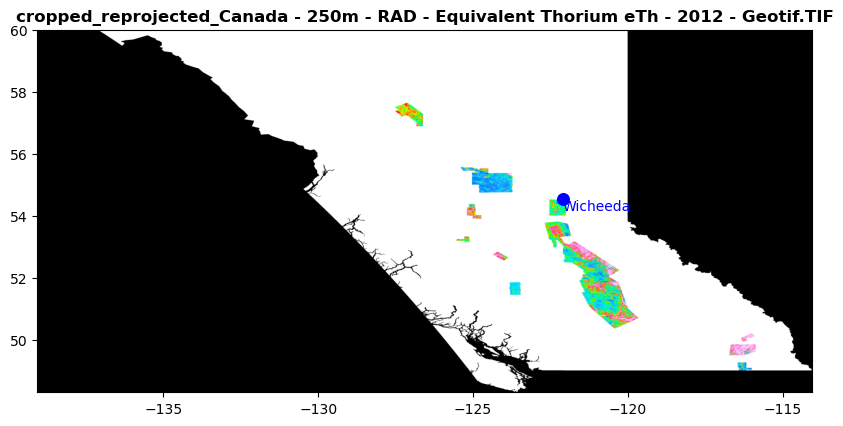

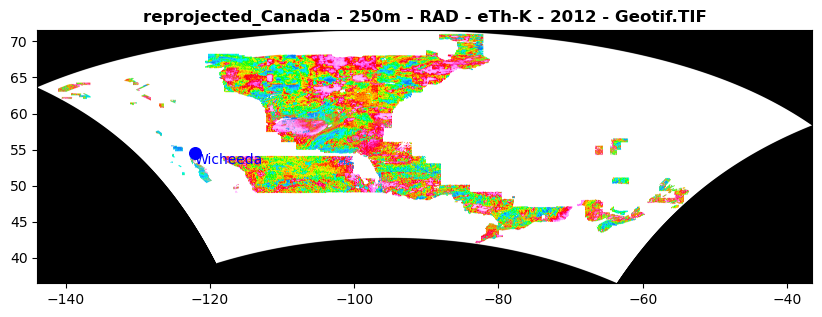

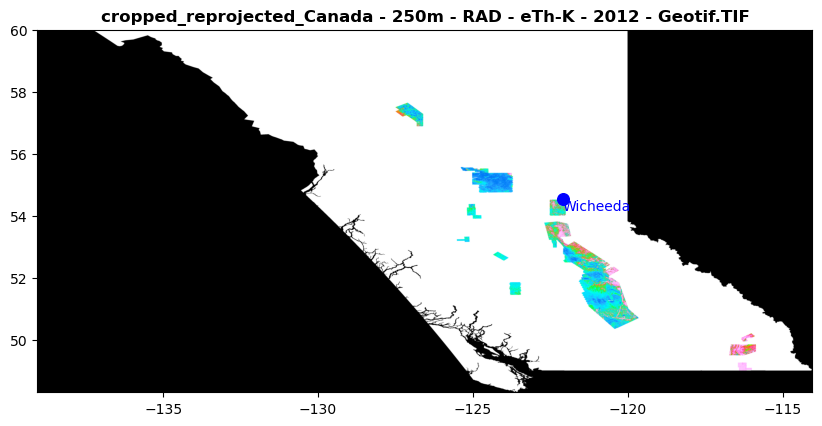

In [20]:
wicheeda = bc_cm[bc_cm['Commoditie']=='Rare earth elements']
# Example usage of the function with a directory and the point of interest loaded as GeoDataFrame
interactive_plot_raster(r"datasets/raster/cropped_reprojected", wicheeda)